In [2]:
!pip install pytesseract
!pip install mysql-connector-python




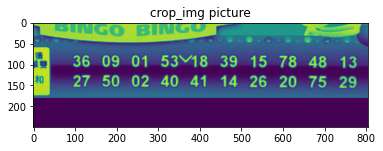

In [58]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import pytesseract
from PIL import Image
from matplotlib import pyplot as plt
import re
import cv2
import numpy as np

img = Image.open('2.jpg')
area = (225, 450,
        1030, 700)
crop_img = img.crop(area)
img = cv2.cvtColor(np.asarray(crop_img),cv2.COLOR_RGB2BGR)  
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = cv2.imread("1.jpg",0)

plt.imshow(img)
plt.title('crop_img picture')
plt.show()


#膨脹
# erosion
#腐蝕
# dilation


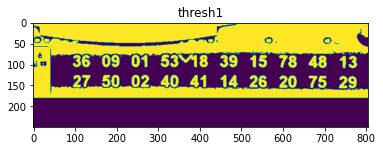

In [67]:
#二值化
ret,thresh1 = cv2.threshold(img,60,255,cv2.THRESH_BINARY)

plt.imshow(thresh1)
plt.title('thresh1')
plt.show()


# #腐蝕
# dilation = cv2.dilate(thresh1, kernel, iterations = 1)

# plt.imshow(dilation)
# plt.title('dilation')
# plt.show()

# #膨脹
# erosion = cv2.erode(dilation, kernel, iterations = 1)


# plt.imshow(erosion)
# plt.title('erosion')
# plt.show()





num = pytesseract.image_to_string(thresh1)
num = re.sub(r'\D', " ", num)
print (num)

In [62]:
image = cv2.cvtColor(np.asarray(cropped_img),cv2.COLOR_RGB2BGR)  
kernel = np.ones((3,3), np.uint8)

#膨脹
erosion = cv2.erode(image, kernel, iterations = 2)

#腐蝕
dilation = cv2.dilate(image, kernel, iterations = 1)

plt.imshow(erosion)
plt.title('erosion')
plt.show()

plt.imshow(dilation)
plt.title('dilation')
plt.show()



# cv2.imshow('Result', dilation)
# # cv2.imshow('Input', image)
# cv2.imshow('Result', erosion)
cv2.waitKey(0)

TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [54]:
import cv2
bingoNums = []
kernel = np.ones((3,3), np.uint8)
for i in range(2):
    for j in range(10):
        if i==1:
            area = ( (j*80)+(j*2)+220, 540,
                (j*80)+(j*2)+280, 595)
        else:
            area = ( (j*80)+(j*2)+225, 450,
               (j*80)+(j*2)+280, 505)
        cropped_img = img.crop(area)
        import pdb
        pdb.set_trace()
        image = cv2.cvtColor(np.array(cropped_img),cv2.COLOR_RGB2BGR)  

        #膨脹
        erosion = cv2.erode(image, kernel, iterations = 2)


        plt.imshow(cropped_img)
        plt.title('my picture')
        plt.show()
#         bingoNums.append(pytesseract.image_to_string(erosion))
print (bingoNums)

AttributeError: 'numpy.ndarray' object has no attribute 'crop'

In [ ]:
area = (225, 460,
        280, 505)
cropped_img = img.crop(area)

plt.imshow(cropped_img)
plt.title('my picture')
plt.show()

-1

In [ ]:
#encoding:utf-8
import cv2  
import numpy as np  

#读取图片
src = cv2.imread('test02.png', cv2.IMREAD_UNCHANGED)

#设置卷积核
kernel = np.ones((5,5), np.uint8)

#图像膨胀处理
erosion = cv2.dilate(src, kernel)

#显示图像
cv2.imshow("src", src)
cv2.imshow("result", erosion)

#等待显示
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import mysql.connector
from mysql.connector import Error
import pdb
try:
    # 連接 MySQL/MariaDB 資料庫
    connection = mysql.connector.connect(
        host='154.92.99.116',          # 主機名稱
        database='bingo77', # 資料庫名稱
        user='bingo77',        # 帳號
        password='bingo77-77t-0914')  # 密碼
    pdb.set_trace()
    if connection.is_connected():

        # 顯示資料庫版本
        db_Info = connection.get_server_info()
        print("資料庫版本：", db_Info)

        # 顯示目前使用的資料庫
        cursor = connection.cursor()
        cursor.execute("SELECT DATABASE();")
        record = cursor.fetchone()
        print("目前使用的資料庫：", record)

except Error as e:
    print("資料庫連接失敗：", e)

if (connection.is_connected()):
    cursor.close()
    connection.close()
    print("資料庫連線已關閉")